In [3]:
import os 
os.chdir("..")


In [4]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
mode = "damping"
dtt = 1e-6
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)

total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt)
times = np.arange(0, total_time+ dt, dt)

def load_liks(itrajj, mode="damping"):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params(pars)

    total_time, dt = get_total_time_dt(params, ppp=1000, dt=dtt)
    
    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    pars = give_def_params_discrimination(flip=1, mode=mode)
    params, exp_path = check_params(pars)
    total_time, dt = get_total_time_dt(params, ppp=1000,dt=dtt)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    log_lik_ratio_swap = logliks_swap[:,0] - logliks_swap[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap

In [9]:
indfin = np.argmin(np.abs(times - 4))
times = times[:indfin]


indis = np.logspace(2,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]

timind = [times[ind] for ind in indis]

def decide_stop(l, a, b):
    if a<=l<=b:
        return 0
    else:
        return 1

In [16]:
aa, bb = load_liks(27, mode="damping")

FileNotFoundError: [Errno 2] No such file or directory: '/data/uab-giq/scratch/matias/quantera/trajectories/discrimination/[[87.96459430051421, 0.0, 14.0, 0.9, 2261.946710584651], [119.38052083641213, 0.0, 14.0, 0.9, 2261.946710584651]]/27itraj/hybrid_method/4_total_time/1e-06_dtlogliks.npy'

In [ ]:
mode = "damping"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)
total_time, dt = get_total_time_dt(params, ppp=1000, dt=1e-5)


times, logliks, states, signals, params = load_data_discrimination(exp_path=exp_path, total_time=total_time, dt=dt, itraj=10)
ll0 = logliks
l1  = logliks[:,1] - logliks[:,0]

pars = give_def_params_discrimination(flip=1, mode = mode)
params, exp_path = check_params(pars)
total_time, dt = get_total_time_dt(params, ppp=1000, dt=1e-5)

times, logliks, states, signals, params = load_data_discrimination(exp_path=exp_path, total_time=total_time, dt=dt, itraj=10)
ll1 = logliks
l0  = logliks[:,0] - logliks[:,1]

In [95]:
mode = "damping"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params(pars)
total_time, dt = get_total_time_dt(params, ppp=1000, dt=1e-5)
liks0 = load_data_discrimination_liks(exp_path=exp_path, total_time=total_time, dt=dt, itraj=10)

In [96]:
l01, l11 = liks0.T

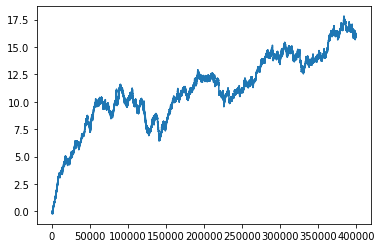

In [98]:
plt.plot(l11-l01)

array([[8.7964592e+01, 0.0000000e+00, 1.4000000e+01, 8.9999998e-01,
        2.2619468e+03],
       [1.1938052e+02, 0.0000000e+00, 1.4000000e+01, 8.9999998e-01,
        2.2619468e+03]], dtype=float32)

In [18]:
boundsB = np.arange(3,5,.5)


deter, stoch = {}, {}
deter["h0/h1"]  = {k:[] for k in range(len(boundsB))}
deter["h1/h0"] = {k:[] for k in range(len(boundsB))}

stoch["h1/h0"] = {}
stoch["h0/h1"] = {}
stop = {}
stop["h1/h0"] = {i:[] for i in range(1,2)}
stop["h0/h1"] = {i:[] for i in range(1,2)}



itraj = 1
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
log_lik_ratio = log_lik_ratio[:indfin]
log_lik_ratio_swap = log_lik_ratio_swap[:indfin]

def get_stop_time(log_lik_ratio,b):
    ind_times = np.argmin(np.logical_and(log_lik_ratio <= b, log_lik_ratio >= -b))
    if ind_times !=0:
        return times[ind_times]
    else:
        return np.nan

ll = log_lik_ratio
ll0 = log_lik_ratio_swap
for time_index in tqdm(indis):
    for indb, b in enumerate(boundsB):
        h0_deter = log_lik_ratio[time_index] <= b
        h1_deter = log_lik_ratio_swap[time_index] <= b
        deter["h0/h1"][indb].append(int(h0_deter))
        deter["h1/h0"][indb].append(int(h0_deter))
for b in boundsB:
    stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
    stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
n=1

Ntrajs=1000

for itraj in tqdm(range(2,Ntrajs)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        log_lik_ratio = log_lik_ratio[:indfin]
        log_lik_ratio_swap = log_lik_ratio_swap[:indfin]
        
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            for indb, b in enumerate(boundsB):
                h0_deter = log_lik_ratio[time_index] <= b
                h1_deter = log_lik_ratio_swap[time_index] <= b
                deter["h0/h1"][indb][ind] +=  (int(h0_deter) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(h0_deter) - deter["h1/h0"][indb][ind])/n
            
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))
    except Exception:
        pass

100%|██████████| 998/998 [00:47<00:00, 20.93it/s] 


In [41]:
### compute stopping time

stopps1 = [np.array(stop["h0/h1"][k])[~np.isnan(stop["h0/h1"][k])] for k in stop["h0/h1"].keys()]
stopps0 = [np.array(stop["h1/h0"][k])[~np.isnan(stop["h1/h0"][k])] for k in stop["h1/h0"].keys()]

ind_max_traj1 = np.argmax([len(k) for k in stopps1])
ind_max_traj0 = np.argmax([len(k) for k in stopps0])


stop_time1 = stopps1[ind_max_traj1]
stop_time1_sq = stopps1[ind_max_traj1]**2
ns1 = 2*np.ones(len(stopps1[ind_max_traj1]))

stop_time0 = stopps0[ind_max_traj0]
stop_time0_sq = stopps0[ind_max_traj1]**2
ns0 = 2*np.ones(len(stopps0[ind_max_traj0]))

itrajs1 = list(range(1,Ntrajs))
itrajs0 = list(range(1,Ntrajs))
itrajs1.remove(ind_max_traj1+1)
itrajs0.remove(ind_max_traj0+1)

for i in tqdm(itrajs1):
    for ind,b in enumerate(boundsB[:len(stopps1[ind_max_traj1])]):
        try: 
            stop_time1[ind] += (stopps1[i][ind] - stop_time1[ind])/ns1[ind]
            stop_time1_sq[ind] += (stopps1[i][ind]**2 - stop_time1_sq[ind])/ns1[ind]
            
            ns1[ind] +=1
        except Exception:
            pass
        
for i in tqdm(itrajs0):
    for ind,b in enumerate(boundsB[:len(stopps0[ind_max_traj0])]):
        try: 
            stop_time0[ind] += (stopps0[i][ind] - stop_time0[ind])/ns0[ind]
            stop_time0_sq[ind] += (stopps0[i][ind]**2 - stop_time0_sq[ind])/ns0[ind]
            
            ns0[ind] +=1
        except Exception:
            pass

100%|██████████| 998/998 [00:00<00:00, 37858.29it/s]


In [43]:
stop_time1

array([0.50588785, 0.60105605, 0.70260361, 0.80083754])

In [22]:
import os 
freq_dir = get_def_path(mode="hypothesis_testing")+"damping_discrimination/set5/"
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"times_here", timind)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))

In [23]:
alpha = np.array(list(deter["h0/h1"].values()))
beta = np.array(list(deter["h1/h0"].values()))

Text(0.5, 0, '$P_e = \\frac{1}{2} (\\alpha + \\beta)$')

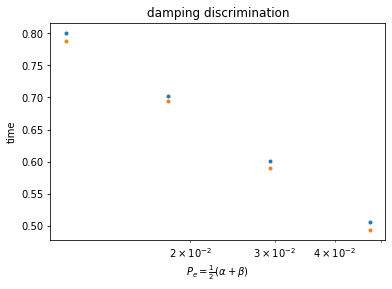

In [40]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))

ax = plt.subplot(111)
plt.title("{} discrimination".format(mode))
lin=6
ax.plot([avg_err_alpha(b) for b in boundsB[:len(stop_time1)]],stop_time1, '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot([avg_err_alpha(b) for b in boundsB[:len(stop_time1)]],stop_time0, '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
#ax.plot(0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),[times[ind] for ind in indis] ,color="black", label="deterministic")
#ax.scatter( 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),[times[ind] for ind in indis], color="black")

ax.set_xscale("log")
ax.set_ylabel("time")
ax.set_xlabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
#ax.legend(prop={"size":15})

In [38]:
ind_stop_times = [np.argmin(np.abs(times - stop_time0[ind])) for ind in range(len(stop_time0))]

In [39]:
alpha = np.array(deter["h1/h0"])

In [44]:
indis_alpha_is_b = [np.argmin(np.abs(alpha - avg_err_alpha(b))) for b in boundsB]

In [45]:
times_det_alpha_is_b = [times[i] for i in indis_alpha_is_b]

In [56]:
timind = [times[ind] for ind in indis]

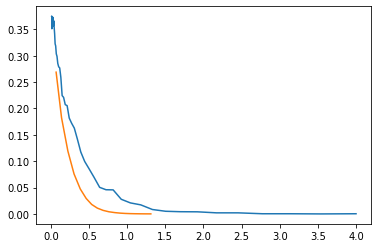

In [60]:
#plt.plot(timind, [avg_err_alpha(b) for b in boundsB])
plt.plot(timind, alpha)
plt.plot(stop_time0, [avg_err_alpha(b) for b in boundsB])

In [50]:
times_det_alpha_is_b

[0.002,
 0.0026000000000000003,
 0.003,
 0.0033,
 0.0035,
 0.0037,
 0.0039000000000000003,
 0.004,
 0.004,
 0.0043,
 0.0044,
 0.0044,
 0.0046,
 0.0046,
 0.0046,
 0.0046,
 0.0048000000000000004,
 0.0048000000000000004]

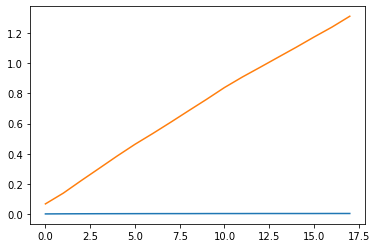

In [48]:
plt.plot(times_det_alpha_is_b)
plt.plot(stop_time0)

In [ ]:
for itraj in tqdm(range(2,3000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        stop["h0/h1"][itraj] = []
        stop["h1/h0"][itraj] = []
        ll += log_lik_ratio
        ll0+= log_lik_ratio_swap
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
        for b in boundsB:
            stop["h0/h1"][itraj].append(get_stop_time(log_lik_ratio, b))
            stop["h1/h0"][itraj].append(get_stop_time(log_lik_ratio_swap, b))


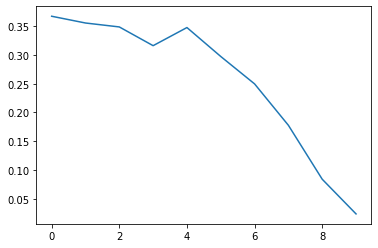

In [24]:
plt.plot(np.array(deter["h1/h0"]))

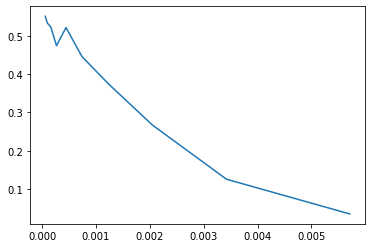

In [21]:
plt.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]))

NameError: name 'ind_max_traj' is not defined

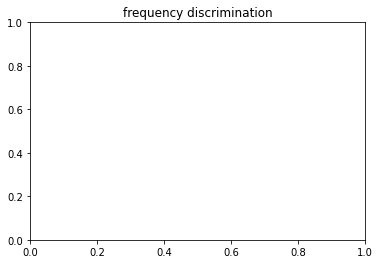

In [120]:
ax = plt.subplot(111)
plt.title("frequency discrimination")
lin=6
ax.plot(stop_time1, [avg_err_alpha(b) for b in boundsB[:len(stopps1[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H1}$', linewidth=lin)
ax.plot(stop_time0, [avg_err_alpha(b) for b in boundsB[:len(stopps0[ind_max_traj])]], '.',label=r'$\langle \tau \rangle_{|H0}$', linewidth=lin)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]),color="black", label="deterministic")
ax.scatter([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), color="black")

ax.set_xlabel("time")
ax.set_ylabel(r'$P_e = \frac{1}{2} (\alpha + \beta)$')
ax.legend(prop={"size":15})

In [471]:
ll *= len(stop["h0/h1"])**2
ll0 *= len(stop["h0/h1"])**2

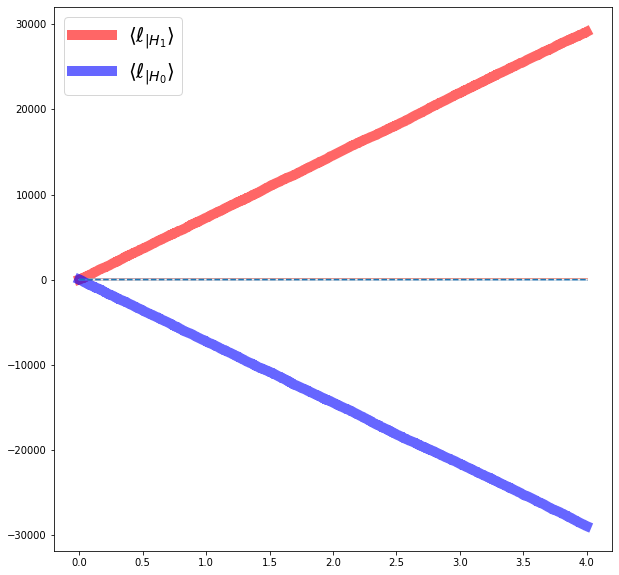

In [14]:

colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")

plt.figure(figsize=(10,10))
alphaMean=0.6
plt.plot(times, ll[:-1],linewidth=10, alpha=alphaMean,  color="red", label=r'$\langle \ell_{|H_1}\rangle$')
Ntraj = 10
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]
             
for ii, itraj in enumerate(range(1,Ntraj)):
    log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
    plt.plot(times,log_lik_ratio[:-1], c=c1[ii], alpha=0.75)
    plt.plot(times, log_lik_ratio_swap[:-1],c=c0[ii], alpha=0.75)
plt.plot(times,ll0[:-1], linewidth=10, alpha=alphaMean, color="blue", label=r'$\langle \ell_{|H_0}\rangle$')
plt.plot(times, np.zeros(len(ll0)-1),"--")

plt.legend(prop={"size":20})

In [476]:
import os 
freq_dir = get_def_path(mode="continuous")+"freq_discrimination/"
os.makedirs(freq_dir, exist_ok=True)

np.save(freq_dir+"mean_likelihood_0", ll0)
np.save(freq_dir+"mean_likelihood_1", ll)
np.save(freq_dir+"boundsB", boundsB)
np.save(freq_dir+"stop_time1",stop_time1)
np.save(freq_dir+"stop_time0",stop_time0)
np.save(freq_dir+"alpha_deter",np.array(deter["h0/h1"]))
np.save(freq_dir+"beta_deter",np.array(deter["h1/h0"]))